# Visualizing a piano teaching "family tree"

I would like in this notebook to create the data structure necessary for a "teaching family tree", i.e. a graph of relations "X taught Y".

As usual, my boilerplate code:

In [1]:
%matplotlib inline
import json
import pandas
import sqlalchemy
# define DB
PGHOST = "192.168.11.2"
PGDATABASE = "musicbrainz_db"
PGUSER = "musicbrainz"
PGPASSWORD = "musicbrainz"

engine = sqlalchemy.create_engine(
   'postgresql+psycopg2://{PGUSER}:{PGPASSWORD}@{PGHOST}/{PGDATABASE}'.format(**locals()),
    isolation_level='READ UNCOMMITTED')

# helper function
def sql(query, **kwargs):
    params = globals().copy()
    params.update(kwargs)
    return pandas.read_sql(query, engine, params=params)

## Basic example

Let's start simply by finding [Heinrich Neuhaus](https://en.wikipedia.org/wiki/Heinrich_Neuhaus)'s teachers and students

In [2]:
artist_name = 'Heinrich Neuhaus'

In [3]:
artist = sql("""
SELECT a.id,
       a.gid AS mbid,
       a.name,
       aa.name,
       to_date(to_char(a.begin_date_year, '9999') || 
               to_char(a.begin_date_month, '99') || 
               to_char(a.begin_date_day, '99'), 'YYYY MM DD') AS start,
       to_date(to_char(a.end_date_year, '9999') || 
               to_char(a.end_date_month, '99') || 
               to_char(a.end_date_day, '99'), 'YYYY MM DD') AS end
  FROM artist       AS a
  JOIN artist_alias AS aa ON aa.artist=a.id
 WHERE aa.name = %(artist_name)s;
""")
artist_id = artist['id'][0]
artist_mbid = artist['mbid'][0]
artist

,id,mbid,name,name,start,end
0,605778,2b075237-6e90-4e78-a4f8-a66170c682fe,Генрих Густавович Нейгауз,Heinrich Neuhaus,1888-04-12,1964-10-10


We'll keep the MBID for later

Let's explore MusicBrainz relations to find the proper "X taught Y":

In [4]:
relation = sql("""
SELECT id, name, description
  FROM link_type
 WHERE description ILIKE '%%teach%%';
""")
relation_id = relation['id'][0]
print(relation.ix[0].id, relation.ix[0].description)
print(relation.ix[1].id, relation.ix[1].description)

847 This relationship indicates that a person was another's teacher/student.
893 This relationship indicates that a person was a teacher at an event (e.g. a masterclass).


So the one we need is relation id=847 (the other one is for events)

Let's now find the direct students:

In [5]:
df_students = sql("""
SELECT student.name,
       student.sort_name,
       student.gid AS mbid
  FROM artist          AS student
  JOIN l_artist_artist AS laa     ON laa.entity1 = student.id
  JOIN artist          AS teacher ON laa.entity0 = teacher.id
 WHERE teacher.gid = %(artist_mbid)s;
""")
df_students

,name,sort_name,mbid
0,Святослав Теофилович Рихтер,"Richter, Sviatoslav Teofilovich",2014bfbb-c65d-45dc-9973-35bead3833fa
1,Эмиль Григорьевич Гилельс,"Gilels, Emil Grigoryevich",88b4ad33-63ba-4923-947e-26a720631156
2,Radu Lupu,"Lupu, Radu",bec02ec4-34be-43db-9be1-006606174fd2
3,Алексей Любимов,"Lubimov, Alexei",385cb39b-f06c-4635-84fd-ecc8fff56c97
4,Анатолий Иванович Ведерников,"Vedernikov, Anatoly Ivanovich",fcfc3731-3b67-4b1d-8096-6a1537b61daf
5,Valentina Kameníková,"Kameníková, Valentina",ab095a51-18c1-43ab-ba96-2b1c8cdb7019
6,Ryszard Bakst,"Bakst, Ryszard",d1cea2e7-0ef6-4434-8890-61f22f85827c
7,Heljo Sepp,"Sepp, Heljo",a460e14c-a004-4ead-be61-8d3956c3de17
8,Yuliy Meitus,"Meitus, Yuliy",ff5ce524-7794-4e84-ad42-a586c29c4f90


So we have a few of them in MusicBrainz.

And teachers:

In [6]:
df_teachers = sql("""
SELECT teacher.name,
       teacher.sort_name,
       teacher.gid AS mbid
FROM artist AS student
JOIN l_artist_artist AS laa ON laa.entity1 = student.id
JOIN artist AS teacher ON laa.entity0 = teacher.id
WHERE student.gid = %(artist_mbid)s;
""")
df_teachers

,name,sort_name,mbid
0,Leopold Godowsky,"Godowsky, Leopold",f5b8d14c-3adb-4cd3-aa97-140a557c7302
1,Karl Heinrich Barth,"Barth, Karl Heinrich",695de63f-d20a-4e8f-bba9-2ae645f109a9


Now I want to use the [visjs](http://visjs.org) library to display a graph. My graph requires two javascript arrays:

* 'nodes', to store the node labels and identifiers (I chose to use MBIDs)
* 'edges', to store the links between two MBIDs corresponding to one 'X taught Y' relation

In [7]:
from pprint import pprint
nodes = []
nodes.append({'id': str(artist_mbid), 'label' : artist_name})
nodes.extend([{'id': str(student.mbid), 'label' : student.sort_name} 
              for student in df_students.itertuples()])
nodes.extend([{'id': str(teacher.mbid), 'label' : teacher.sort_name} 
              for teacher in df_teachers.itertuples()])
pprint(nodes)

edges = []
edges.extend([{'from': str(artist_mbid), 'to' : str(student.mbid)} 
              for student in df_students.itertuples()])
edges.extend([{'from': str(teacher.mbid), 'to' : str(artist_mbid) }
               for teacher in df_teachers.itertuples()])
pprint(edges)

with open('./nodes1.json', 'w') as f:
    json.dump(nodes, f)
with open('./edges1.json', 'w') as f:
    json.dump(edges, f)

[{'id': '2b075237-6e90-4e78-a4f8-a66170c682fe', 'label': 'Heinrich Neuhaus'},
 {'id': '2014bfbb-c65d-45dc-9973-35bead3833fa',
  'label': 'Richter, Sviatoslav Teofilovich'},
 {'id': '88b4ad33-63ba-4923-947e-26a720631156',
  'label': 'Gilels, Emil Grigoryevich'},
 {'id': 'bec02ec4-34be-43db-9be1-006606174fd2', 'label': 'Lupu, Radu'},
 {'id': '385cb39b-f06c-4635-84fd-ecc8fff56c97', 'label': 'Lubimov, Alexei'},
 {'id': 'fcfc3731-3b67-4b1d-8096-6a1537b61daf',
  'label': 'Vedernikov, Anatoly Ivanovich'},
 {'id': 'ab095a51-18c1-43ab-ba96-2b1c8cdb7019',
  'label': 'Kameníková, Valentina'},
 {'id': 'd1cea2e7-0ef6-4434-8890-61f22f85827c', 'label': 'Bakst, Ryszard'},
 {'id': 'a460e14c-a004-4ead-be61-8d3956c3de17', 'label': 'Sepp, Heljo'},
 {'id': 'ff5ce524-7794-4e84-ad42-a586c29c4f90', 'label': 'Meitus, Yuliy'},
 {'id': 'f5b8d14c-3adb-4cd3-aa97-140a557c7302', 'label': 'Godowsky, Leopold'},
 {'id': '695de63f-d20a-4e8f-bba9-2ae645f109a9',
  'label': 'Barth, Karl Heinrich'}]
[{'from': '2b075237-6e90

The output graph is available on [github.io](https://loujine.github.io/musicbrainz-dataviz/index.html#neuhaus-tree), it looks like:

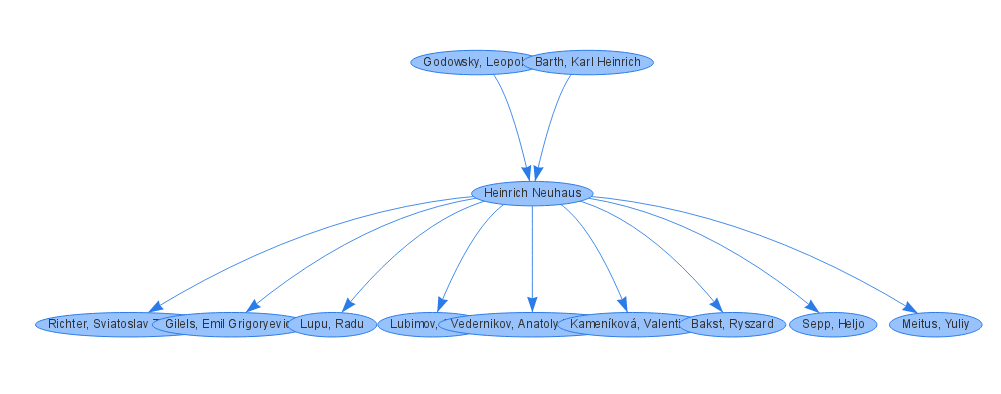

In [8]:
from IPython.display import Image
Image(filename='img/tree1.png')

## Can we make it recursive?

It would be nice to have our code recursively, to go back to the "original" teacher up to the latest student of this "family".

In [9]:
def teachers_from_mbid(mbid):
    df = sql("""
SELECT teacher.name,
       teacher.sort_name,
       teacher.gid        AS mbid
FROM artist          AS student
JOIN l_artist_artist AS laa     ON laa.entity1 = student.id
JOIN artist          AS teacher ON laa.entity0 = teacher.id
WHERE student.gid = %(mbid)s;
    """, mbid=mbid)
    df.mbid = df.mbid.astype(str)
    return df

In [10]:
def students_from_mbid(mbid):
    df = sql("""
SELECT student.name,
       student.sort_name,
       student.gid        AS mbid
  FROM artist          AS student
  JOIN l_artist_artist AS laa     ON laa.entity1 = student.id
  JOIN artist          AS teacher ON laa.entity0 = teacher.id
 WHERE teacher.gid = %(mbid)s;
    """, mbid=mbid)
    df.mbid = df.mbid.astype(str)
    return df

In [11]:
artist_mbid = '2b075237-6e90-4e78-a4f8-a66170c682fe' # Neuhaus

We try to apply the 'find new teachers' function on known teachers. We of course avoid calling the function on teachers we already analyzed.

In [12]:
mbids_to_do = [artist_mbid]
nodes = {artist_mbid: {'id': artist_mbid, 'label' : artist_name}}
edges = []
while mbids_to_do:
    mbid = mbids_to_do.pop()
    df = teachers_from_mbid(mbid)
    for artist in df.itertuples():
        mbids_to_do.append(artist.mbid)
        if artist.mbid not in nodes:
            nodes[artist.mbid] = {'id': artist.mbid, 'label' : artist.name}
            edges.append({'from': artist.mbid, 'to' : mbid})

In [13]:
print("Nodes (persons): {}".format(len(nodes)))
print("Edges (links): {}".format(len(edges)))

with open('./nodes2.json', 'w') as f:
    json.dump(list(nodes.values()), f)
with open('./edges2.json', 'w') as f:
    json.dump(edges, f)

Nodes (persons): 66
Edges (links): 65


So if we look for all indirect teachers of Neuhaus, we reach around 66 persons (nodes) and 65 relations, once we remove all possible duplicates. The resulting graph looks like that:

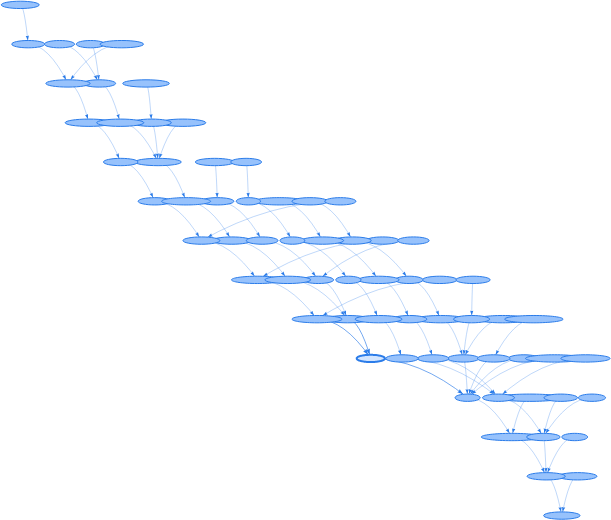

In [14]:
from IPython.display import Image
Image(filename='img/tree2.png')

Neuhaus is of course the last node. One cannot see the artists name at this scale but the original is on [github.io](https://loujine.github.io/musicbrainz-dataviz/index.html#neuhaus-teachers)

What about students?

In [15]:
mbids_to_do = [artist_mbid]
nodes = {artist_mbid: {'id': artist_mbid, 'label' : artist_name}}
edges = []
while mbids_to_do:
    mbid = mbids_to_do.pop()
    df = students_from_mbid(mbid)
    for artist in df.itertuples():
        mbids_to_do.append(artist.mbid)
        if artist.mbid not in nodes:
            nodes[artist.mbid] = {'id': artist.mbid, 'label' : artist.name}
            edges.append({'from': mbid, 'to' : artist.mbid})            

print("Nodes (persons): {}".format(len(nodes)))
print("Edges (links): {}".format(len(edges)))

with open('./nodes3.json', 'w') as f:
    json.dump(list(nodes.values()), f)
with open('./edges3.json', 'w') as f:
    json.dump(edges, f)

Nodes (persons): 55
Edges (links): 54


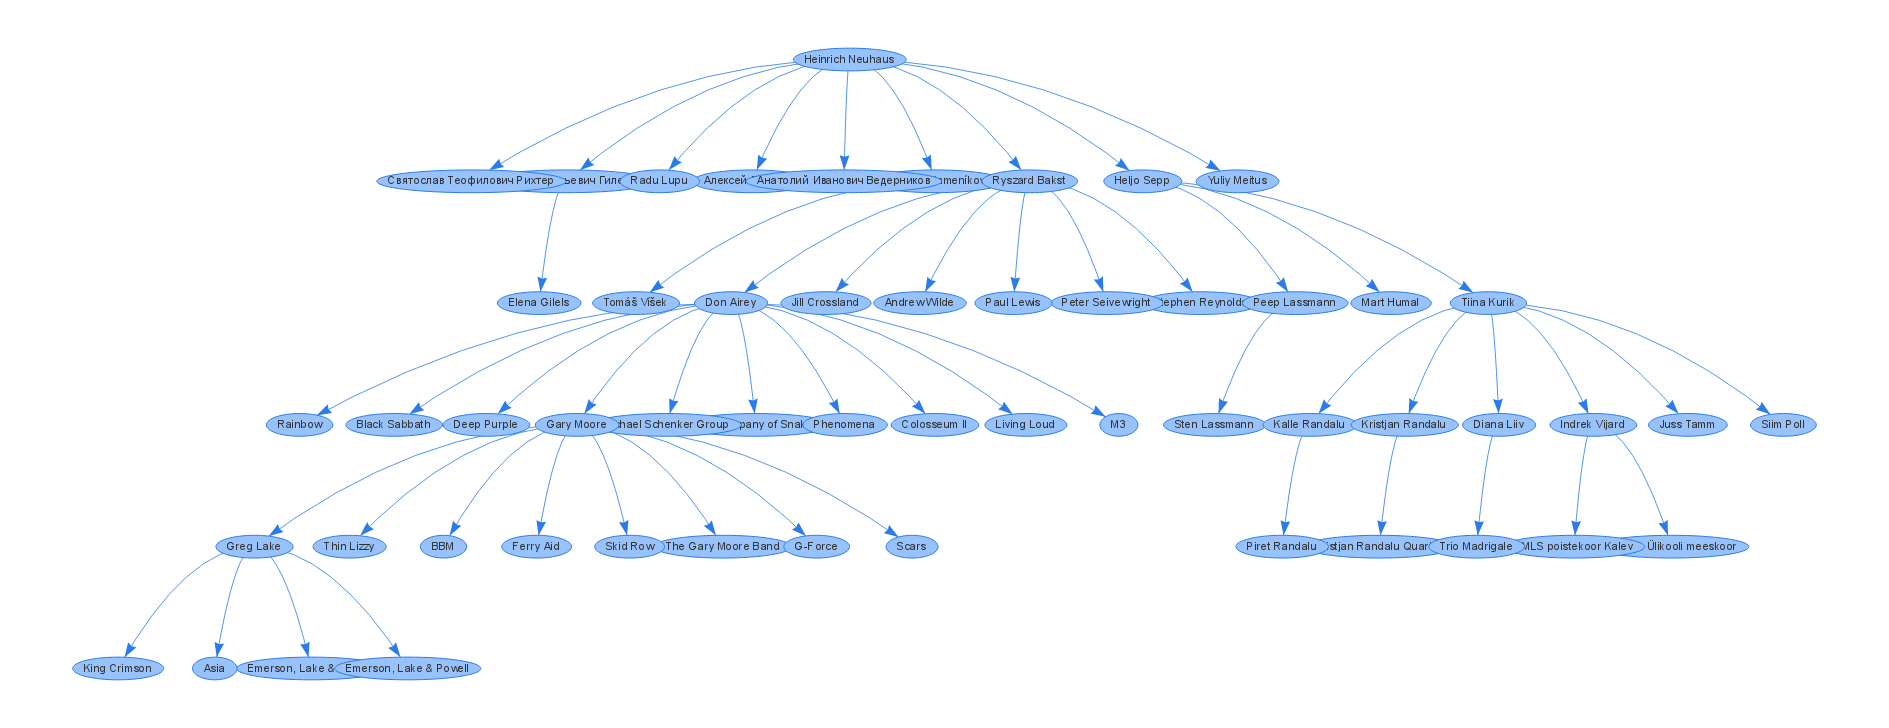

In [16]:
from IPython.display import Image
Image(filename='img/tree3.png')

Nice! I didn't know Neuhaus indirectly taught Black Sabbath and Deep Purple...

We could continue by looking at both teachers and students at the same time... but in this case we have to be very careful about loops that would make our code look for the same artists several times or even infinitely (edit: of course my code had a bug and ran in an infinite loop regarding Martinu and another artist who both taught and were teached by each other).

## Another example

Let's look at a very influent french piano teacher:

In [17]:
artist_name = 'Alfred Cortot'

In [18]:
artist = sql("""
SELECT a.id,
       a.gid AS mbid,
       a.name,
       to_date(to_char(a.begin_date_year, '9999') || 
               to_char(a.begin_date_month, '99') || 
               to_char(a.begin_date_day, '99'), 'YYYY MM DD') AS start,
       to_date(to_char(a.end_date_year, '9999') || 
               to_char(a.end_date_month, '99') || 
               to_char(a.end_date_day, '99'), 'YYYY MM DD') AS end
  FROM artist       AS a
 WHERE a.name = %(artist_name)s;
""")
artist_id = artist['id'][0]
artist_mbid = str(artist['mbid'][0])
artist

,id,mbid,name,start,end
0,421748,c063351f-8877-415f-b4bd-c65f60cedb66,Alfred Cortot,1877-09-26,1962-06-15


In [19]:
mbids_to_do = [artist_mbid]
nodes = {artist_mbid: {'id': artist_mbid, 'label' : artist_name}}
edges = []
while mbids_to_do:
    mbid = mbids_to_do.pop()
    df = teachers_from_mbid(mbid)
    for artist in df.itertuples():
        mbids_to_do.append(artist.mbid)
        if artist.mbid not in nodes:
            nodes[artist.mbid] = {'id': artist.mbid, 'label' : artist.name}
            edges.append({'from': artist.mbid, 'to' : mbid})
mbids_to_do = [artist_mbid]
while mbids_to_do:
    mbid = mbids_to_do.pop()
    df = students_from_mbid(mbid)
    for artist in df.itertuples():
        if artist.mbid not in nodes:
            mbids_to_do.append(artist.mbid)
            nodes[artist.mbid] = {'id': artist.mbid, 'label' : artist.name}
            edges.append({'from': mbid, 'to' : artist.mbid})            

print("Nodes (persons): {}".format(len(nodes)))
print("Edges (links): {}".format(len(edges)))

with open('./nodes4.json', 'w') as f:
    json.dump(list(nodes.values()), f)
with open('./edges4.json', 'w') as f:
    json.dump(edges, f)

Nodes (persons): 37
Edges (links): 36


Screenshot:

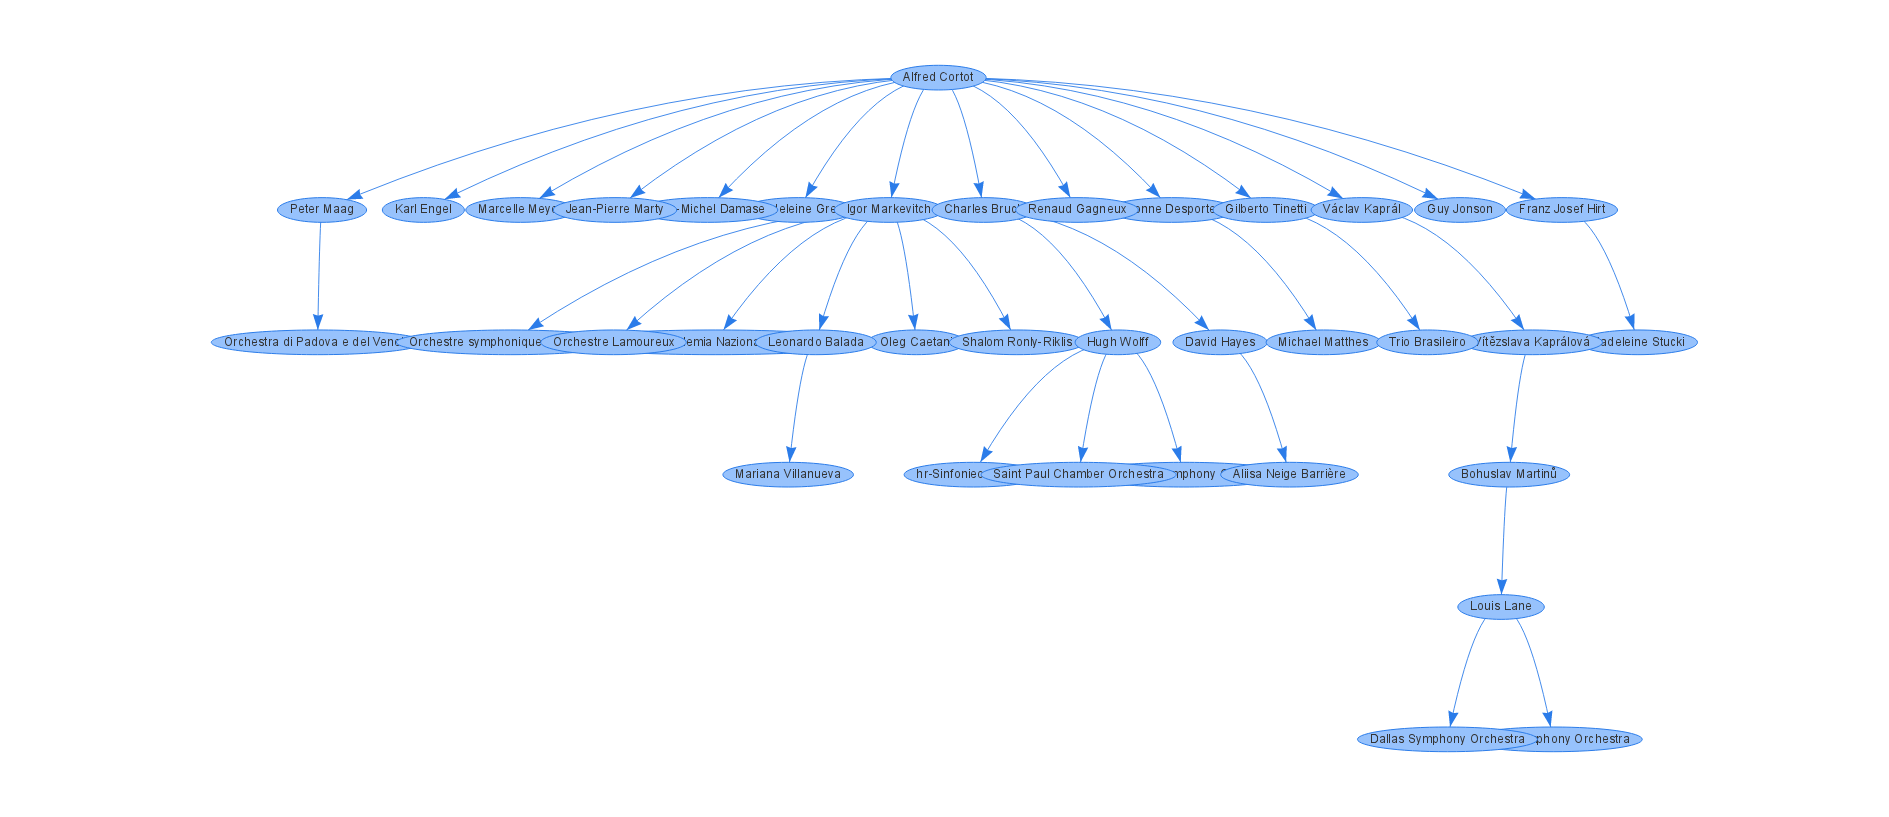

In [21]:
from IPython.display import Image
Image(filename='img/tree4.png')

Why are there orchestras here? This is a good question... the kind of questions I'm  discovering thanks to this tool :)